<span style="color: blue; font-size: 20px; font-weight: bold;">Комментарий ревьюера</span>

<span style="color: blue">Привет, Алексей! Это снова Павел Григорьев, и я буду проверять этот проект.<br>Моя основная цель - не указать на совершённые тобой ошибки, а поделиться своим опытом и помочь тебе совершенствоваться как профессионалу.<br>Спасибо за проделанную работу!</span>
<details>
	<summary><u>Инструкция по организационным моментам (кликабельно)</u>⤵</summary>
<span style="color: blue">Я буду использовать различные цвета, чтобы было удобнее воспринимать мои комментарии:</span>


---


<span style="color: blue">синий текст - просто текст комментария</span>

<span style="color: green">✔️ и зеленый текст - все отлично</span>

<span style="color: orange">⚠️ и оранжевый текст - сделано все правильно, однако есть рекомендации, на что стоит обратить внимание</span>

<span style="color: red">❌ и красный текст - есть недочеты</span>


</details>    
</br>
<span style="color: blue">Пожалуйста, не удаляй мои комментарии в случае возврата работы, так будет проще разобраться, какие были недочеты, а также сразу увидеть исправленное.</span>

<span style="color: blue">Ответы на мои комментарии лучше тоже помечать.<br>
Например: </span><br><span style="color: purple; font-weight: bold">Комментарий студента</span>

<span style="color: blue; font-weight: bold;">Давай смотреть, что получилось!</span>


<span style="color: purple; font-weight: bold">Комментарий студента</span>:<br />
Привет, Павел. Спасибо за твой фидбэк.

# Модель для определения возрастной категории пользователей

- Автор: Ильин А.В.
- Дата: 04.01.2026

**Содержимое проекта**

1. [Цели и задачи проекта](#section1)
2. [Подготовка среды и библиотек](#section2)
3. [Исследовательский анализ данных](#section3)
4. [Предобработка данных](#section4)
5. [Обучение и оценка базовой модели](#section5)
6. [Создание и отбор признаков](#section6)
7. [Подбор гиперпараметров моделей](#section7)
8. [Подготовка артефактов модели для внедрения](#section8)
9. [Выводы о результатах работы](#section9)

<a class='anchor' id="section1"></a>
## Цели и задачи проекта

Разработать модель для определения возрастной категории пользователей. В качестве основной метрики будем использовать F1.

### Описание данных

Данные состоят из шести датасетов.

- `/datasets/ds_s13_users.csv` — информация о возрастной категории пользователя;
- `/datasets/ds_s13_visits.csv` — информация об активности пользователей разных сайтов;
- `/datasets/ads_activity.csv` — информация об активность взаимодействия пользователя с рекламными объявлениями;
- `/datasets/surf_depth.csv` — информация характеризующая глубину перехода пользователя по сайтам во время одной сессии;
- `/datasets/primary_device.csv` — информация о типе основного устройства пользователя для выхода в Интернет;
- `/datasets/cloud_usage.csv` — информация об использование облачных технологий.

### Описание датасета `ds_s13_users`

- `user_id` — уникальный идентификатор пользователя;
- `age_category` — возрастная категория пользователя.

### Описание датасета `ds_s13_visits`

- `user_id` — уникальный идентификатор пользователя;
- `date` — дата посещения сайта;
- `daytime` — анонимизированное время посещения сайта;
- `session_id` — уникальный идентификатор сессии;
- `website_category` — анонимизированная категория сайта.

### Описание датасета `ads_activity`

- `user_id` — уникальный идентификатор пользователя;
- `ads_activity` — характеристика CTR.

### Описание датасета `surf_depth`

- `user_id` — уникальный идентификатор пользователя;
- `surf_depth` — категориальная переменная, характеризующая глубину перехода пользователя по сайтам во время одной сессии.

### Описание датасета `primary_device`

- `user_id` — уникальный идентификатор пользователя;
- `primary_device` — информация о типе основного устройства пользователя для выхода в Интернет.

### Описание датасета `cloud_usage`

- `user_id` — уникальный идентификатор пользователя;
- `cloud_usage` — `True` означает, что пользователь обращается к облачным ресурсам.

## Подготовка среды и библиотек

Установим необходимые библиотеки.

In [1]:
!pip install -q phik
!pip install -q scikit-learn==1.6.1
!pip install -q joblib 

Импортируем библиотеки

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    make_scorer,
    f1_score,
    precision_score,
    recall_score,
    classification_report
)
from sklearn.model_selection import (
    cross_validate,
    GridSearchCV,
    train_test_split,
    StratifiedKFold
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    StandardScaler
)
from sklearn.svm import SVC

from phik import phik_matrix

import joblib

from IPython.display import display

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Хорошее оформление импортов! \
Импорты собраны в одной ячейке, разделены на функциональные группы пустой строкой.</font>

Сделаем необходимые настройки отображения

In [3]:
# Отображать все столбцы
pd.set_option('display.max_columns', None)

# Устанавливаем опцию для отображения всех содержимого в ячейках
pd.set_option('display.max_colwidth', None)

pd.set_option('display.float_format', '{:.6f}'.format)

Пропишем константы

In [4]:
RANDOM_STATE = 42

Выгрузим данные в переменные.

In [5]:
ds_s13_users_df = pd.read_csv('https://code.s3.yandex.net/datasets/ds_s13_users.csv')
ds_s13_visits_df = pd.read_csv('https://code.s3.yandex.net/datasets/ds_s13_visits.csv')
ads_activity_df = pd.read_csv('https://code.s3.yandex.net/datasets/ads_activity.csv')
surf_depth_df = pd.read_csv('https://code.s3.yandex.net/datasets/surf_depth.csv')
primary_device_df = pd.read_csv('https://code.s3.yandex.net/datasets/primary_device.csv')
cloud_usage_df = pd.read_csv('https://code.s3.yandex.net/datasets/cloud_usage.csv')

In [6]:
df_data = {
    'ds_s13_users_df': ds_s13_users_df,
    'ds_s13_visits_df': ds_s13_visits_df,
    'ads_activity_df': ads_activity_df,
    'surf_depth_df': surf_depth_df,
    'primary_device_df': primary_device_df,
    'cloud_usage_df': cloud_usage_df,
}

Посмотрим на данные датафреймов.

In [7]:
for name, data in df_data.items():
    print(f'Данные датафрейма {name}')
    data.info()
    display(data.head())
    print(50 * '-')
    print()

Данные датафрейма ds_s13_users_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5913 entries, 0 to 5912
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       5913 non-null   object
 1   age_category  5913 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 92.5+ KB


,user_id,age_category
0,f545-8c95aefe8d3e5548a689-a5b2fd39,4
1,cb48-5a0d6cde4d86ae10637e-c8ceb6ed,2
2,678b-614cd47d854b9d591db2-000b2e50,0
3,4ac0-dad169100b4a29b20818-b26ae7c5,4
4,f19b-9ac21ca973b41ecfa8c3-6a58191d,0


--------------------------------------------------

Данные датафрейма ds_s13_visits_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065745 entries, 0 to 1065744
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   date              1065745 non-null  object
 1   daytime           1065745 non-null  object
 2   session_id        1065745 non-null  object
 3   user_id           1065745 non-null  object
 4   website_category  1065745 non-null  object
dtypes: object(5)
memory usage: 40.7+ MB


,date,daytime,session_id,user_id,website_category
0,2025-11-01,вечер,066e4e02-8c1f-45eb-a50f-178659abe698,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 17
1,2025-11-01,вечер,0bce1749-3376-439c-9a22-f8ffbba00e9a,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 19
2,2025-11-01,вечер,3445d8c4-221d-4d88-bb6a-a2939fe3c610,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 18
3,2025-11-01,вечер,3bf97286-1d91-4aaa-af4a-ed58eceb8cd2,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 20
4,2025-11-01,вечер,40e22712-3cad-410d-a9f0-13bd8f6911c0,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 05


--------------------------------------------------

Данные датафрейма ads_activity_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5826 entries, 0 to 5825
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       5826 non-null   object
 1   ads_activity  5826 non-null   object
dtypes: object(2)
memory usage: 91.2+ KB


,user_id,ads_activity
0,e318-d8e69c86b543a5fb927c-c36fb6e6,очень часто
1,35cd-a972339dec534f49332c-a8b6d383,редко
2,f7e6-3b29cf9cb7ed4bb00d8f-81534360,очень редко
3,5186-e25a37549e50f45b2b43-178eaabe,умеренно
4,febd-077f277466253ee04ef6-42656680,умеренно


--------------------------------------------------

Данные датафрейма surf_depth_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5715 entries, 0 to 5714
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     5715 non-null   object
 1   surf_depth  5715 non-null   object
dtypes: object(2)
memory usage: 89.4+ KB


,user_id,surf_depth
0,f238-0c4c1e787cce311541b7-736925a0,поверхностно
1,9030-1b562ad80182b6dc27f1-ce811740,глубоко
2,22e0-7c6cadcc45e246b8688d-c43c9b23,поверхностно
3,9d7f-a19f10756378940a49b5-5d03e1ef,поверхностно
4,4233-bb5ae4b09827e5497094-1a4956af,глубоко


--------------------------------------------------

Данные датафрейма primary_device_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5669 entries, 0 to 5668
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         5669 non-null   object
 1   primary_device  5669 non-null   object
dtypes: object(2)
memory usage: 88.7+ KB


,user_id,primary_device
0,d602-ec060db7597a6b8cd4e7-aa625896,смартфон
1,9204-9558455be649d4e77945-b5e25d62,ПК
2,5eea-22babd6a9474b43b9d0b-a39a4cf2,ноутбук
3,c142-0296948e8d08e417de10-2da9523c,смартфон
4,abec-bb4092da51eb2233a928-e44ba074,ПК


--------------------------------------------------

Данные датафрейма cloud_usage_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5680 entries, 0 to 5679
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      5680 non-null   object
 1   cloud_usage  5680 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 50.0+ KB


,user_id,cloud_usage
0,a1e4-91c8a52eb855595e653f-298ce305,False
1,db9a-7b8e9e94448b7fcb19b6-4edca15f,False
2,0d55-9ad768879e9b08ca7ff9-843f76c7,True
3,4baa-43285d10a6d3cc969f2a-b21881d1,False
4,b8cd-cbb2411db005115ca64d-32700c62,False


--------------------------------------------------



<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'> Метод info выведет информацию и без print, print, в данном случае, печатает только слово None в аутпутах.
</font>

На основе предварительного анализа данных можно сказать, что пропуски отсутствуют во всех датафреймах. Типы данных корректные. Названия столбцов не требуют корректировки.

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Данные загружены корректно, первичный осмотр проведен.</font>

## Исследовательский анализ данных

### Анализ дубликатов

Проверим данные на наличие дубликатов.

In [8]:
for name, data in df_data.items():
    print(f'Количество дубликатов в датафрейме {name}: {data.duplicated().sum()}')

Количество дубликатов в датафрейме ds_s13_users_df: 87
Количество дубликатов в датафрейме ds_s13_visits_df: 15750
Количество дубликатов в датафрейме ads_activity_df: 233
Количество дубликатов в датафрейме surf_depth_df: 0
Количество дубликатов в датафрейме primary_device_df: 0
Количество дубликатов в датафрейме cloud_usage_df: 0


В датафремах `ds_s13_users_df`, `ds_s13_visits_df` и `ads_activity_df` были найдены дубликаты, удалим их.

In [9]:
for name, data in df_data.items():
    df_data[name] = data.drop_duplicates()
    print(f'Количество дубликатов в датафрейме {name}: {df_data[name].duplicated().sum()}')

Количество дубликатов в датафрейме ds_s13_users_df: 0
Количество дубликатов в датафрейме ds_s13_visits_df: 0
Количество дубликатов в датафрейме ads_activity_df: 0
Количество дубликатов в датафрейме surf_depth_df: 0
Количество дубликатов в датафрейме primary_device_df: 0
Количество дубликатов в датафрейме cloud_usage_df: 0


Проверим на уникальность значения в столбце `user_id` в каждом датафрейме.

In [10]:
for name, data in df_data.items():
    print(f'Количество дубликатов в столбце user_id в датафрейме {name}: {data["user_id"].duplicated().sum()}')

Количество дубликатов в столбце user_id в датафрейме ds_s13_users_df: 0
Количество дубликатов в столбце user_id в датафрейме ds_s13_visits_df: 1044169
Количество дубликатов в столбце user_id в датафрейме ads_activity_df: 0
Количество дубликатов в столбце user_id в датафрейме surf_depth_df: 0
Количество дубликатов в столбце user_id в датафрейме primary_device_df: 0
Количество дубликатов в столбце user_id в датафрейме cloud_usage_df: 0


В датафрейме `ds_s13_visits_df` остались дубли `user_id`, так как у одного пользователя могло быть несколько сессий.

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green"> 👍</span>

### Подготовка данных и создание общего датафрейма

Напишем функцию которая получает на вход 6 датасетов, делает необходимую обработку и группирует их в общий датафрейм.

In [11]:
def combine_data(ds_s13_users_df, ds_s13_visits_df, ads_activity_df, surf_depth_df, primary_device_df, cloud_usage_df):
    """
    Объединяет данные из различных источников в единый датафрейм для анализа пользователей.

    Функция выполняет предобработку данных о посещениях пользователей, включая расчет
    распределения активности по категориям сайтов, времени суток и среднего количества
    сессий, затем объединяет все данные по идентификатору пользователя.

    Parameters
    ----------
    ds_s13_users_df : pandas.DataFrame
        Основные данные о пользователях. Должен содержать столбец 'user_id'.
    ds_s13_visits_df : pandas.DataFrame
        Данные о посещениях пользователей. Должен содержать столбцы:
        'user_id', 'website_category', 'daytime', 'session_id', 'date'.
    ads_activity_df : pandas.DataFrame
        Данные о рекламной активности пользователей. Должен содержать столбец 'user_id'.
    surf_depth_df : pandas.DataFrame
        Данные о глубине просмотра пользователей. Должен содержать столбец 'user_id'.
    primary_device_df : pandas.DataFrame
        Данные об основных устройствах пользователей. Должен содержать столбец 'user_id'.
    cloud_usage_df : pandas.DataFrame
        Данные об использовании облачных сервисов. Должен содержать столбец 'user_id'.

    Returns
    -------
    pandas.DataFrame
        Объединенный датафрейм со следующими данными:
        - Основные данные пользователей из ds_s13_users_df
        - Преобразованные данные посещений (доли по категориям сайтов, времени суток,
          среднее количество сессий в день)
        - Данные рекламной активности
        - Данные глубины просмотра
        - Данные об основных устройствах
        - Данные об использовании облачных сервисов
    """
    
    df_data = {
        'ds_s13_users_df': ds_s13_users_df,
        'ds_s13_visits_df': ds_s13_visits_df,
        'ads_activity_df': ads_activity_df,
        'surf_depth_df': surf_depth_df,
        'primary_device_df': primary_device_df,
        'cloud_usage_df': cloud_usage_df,
    }
    
    # Рассчитываем долю интернет-активности пользователя которая приходится на посещение сайтов разных категорий,
    # распределение активности по времени суток и среднее количество сессий пользоателя.
    visits_website_cat_pivot = df_data['ds_s13_visits_df'].pivot_table(
        index='user_id',
        columns='website_category',
        aggfunc='size',
        fill_value=0
    )
    visits_website_cat_ratios = visits_website_cat_pivot.div(visits_website_cat_pivot.sum(axis=1), axis=0)
    
    visits_daytime_pivot = df_data['ds_s13_visits_df'].pivot_table(
        index='user_id',
        columns='daytime',
        aggfunc='size',
        fill_value=0
    )
    visits_daytime_ratios = visits_daytime_pivot.div(visits_daytime_pivot.sum(axis=1), axis=0)
    
    daily_sessions = df_data['ds_s13_visits_df'].groupby(['user_id', 'date'])['session_id'].nunique().reset_index()
    
    visits_result = pd.concat([visits_website_cat_ratios, visits_daytime_ratios], axis=1)
    visits_result = visits_result.reset_index()
    visits_result = visits_result.fillna(0)
    
    df_data['ds_s13_visits_df'] = visits_result
    
    # Объединим данные в единый датафрейм по полю user_id, а затем удалим этот столбец, так как это техническая информация.
    df = df_data['ds_s13_users_df']
    for name, data in list(df_data.items()):
        if name != 'ds_s13_users_df':
            df = pd.merge(df, data, on='user_id', how='left')
            
    return df    

In [12]:
#df_data['ds_s13_visits_df'].head()

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'>Датафреймы лучше всегда ограничивать методами .head(), .tail(), sample(). Иначе в выводах ячейки записывается весь Датафрейм, хоть он и не выводится на экран полностью. Такие Аутпуты сильно перегружают тетрадку.</font>

In [13]:
df = combine_data(ds_s13_users_df, ds_s13_visits_df, ads_activity_df, surf_depth_df, primary_device_df, cloud_usage_df)

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> Верно, при объединении таблиц нужно привязаться к уникальному `'user_id'`.</font>

In [14]:
df = df.drop(columns=['user_id'])

In [15]:
df.head()

,age_category,Category 01,Category 02,Category 03,Category 04,Category 05,Category 06,Category 07,Category 08,Category 09,Category 10,Category 11,Category 12,Category 13,Category 14,Category 15,Category 16,Category 17,Category 18,Category 19,Category 20,вечер,день,ночь,утро,ads_activity,surf_depth,primary_device,cloud_usage
0,4,0.067708,0.036458,0.036458,0.062500,0.104167,0.020833,0.000000,0.046875,0.098958,0.026042,0.083333,0.015625,0.031250,0.036458,0.052083,0.041667,0.057292,0.067708,0.072917,0.041667,0.333333,0.359375,0.078125,0.229167,NaN,глубоко,смартфон,False
1,2,0.069444,0.041667,0.104167,0.020833,0.055556,0.034722,0.104167,0.104167,0.041667,0.069444,0.041667,0.041667,0.034722,0.000000,0.062500,0.034722,0.041667,0.027778,0.034722,0.034722,0.395833,0.333333,0.090278,0.180556,умеренно,средне,смартфон,False
2,0,0.009804,0.068627,0.000000,0.107843,0.068627,0.127451,0.000000,0.039216,0.000000,0.009804,0.029412,0.147059,0.127451,0.009804,0.019608,0.029412,0.019608,0.009804,0.117647,0.058824,0.372549,0.303922,0.127451,0.196078,умеренно,средне,смартфон,False
3,4,0.079051,0.003953,0.102767,0.027668,0.106719,0.047431,0.027668,0.063241,0.059289,0.000000,0.063241,0.015810,0.079051,0.019763,0.027668,0.027668,0.063241,0.138340,0.035573,0.011858,0.260870,0.438735,0.071146,0.229249,редко,поверхностно,смартфон,True
4,0,0.065574,0.049180,0.090164,0.032787,0.049180,0.008197,0.049180,0.065574,0.073770,0.040984,0.040984,0.122951,0.000000,0.090164,0.024590,0.032787,0.049180,0.032787,0.024590,0.057377,0.418033,0.336066,0.073770,0.172131,очень редко,поверхностно,смартфон,True


### Анализ признаков

In [16]:
cat_features = df.select_dtypes(include=['object']).columns
num_features = df.select_dtypes(include=['int', 'float']).columns

# Удаляем age_Category из числовых признаков
num_features = num_features.drop(['age_category'], errors='ignore').tolist()

Проверим количество уникальных значений у категориальных признаков.

In [17]:
for column in cat_features:
    print(f"Уникальные значения в столбце {column}:", df[column].unique())

Уникальные значения в столбце ads_activity: [nan 'умеренно' 'редко' 'очень редко' 'очень часто' 'часто']
Уникальные значения в столбце surf_depth: ['глубоко' 'средне' 'поверхностно' nan]
Уникальные значения в столбце primary_device: ['смартфон' 'ноутбук' 'ПК' 'планшет' nan]
Уникальные значения в столбце cloud_usage: [False True nan]


Все столбцы имеют менее 10 значений, поэтому при предобработке будем использовать OneHotEncoding кодирование.

Посмотрим на распределение целевой переменной.

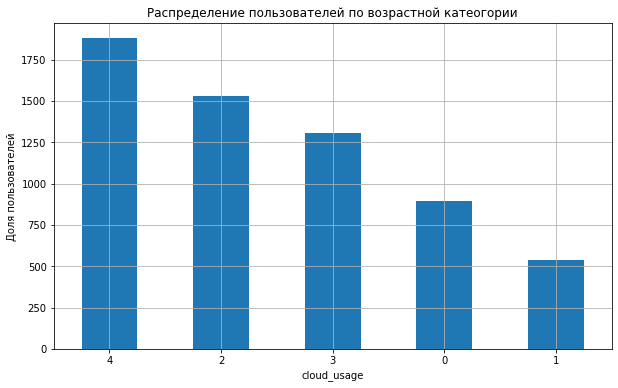

In [18]:
df['age_category'].value_counts().plot(
    kind='bar',
    rot=0,
    title=f'Распределение пользователей по возрастной катеогории',
    figsize=(10, 6)
)

plt.xlabel(column)
plt.ylabel('Доля пользователей')
plt.grid()
plt.show()

В распределении целевой переменной присутствует дисбаланс. Для усреднения метрик будем использовать macro усреднение.

Посмотрим на распределение категориальных признаков в разрезе возрастной категории.

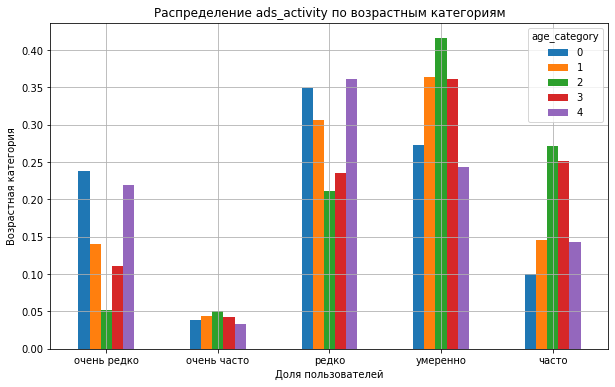

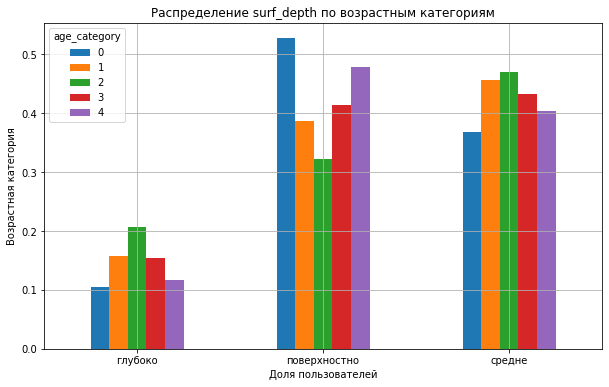

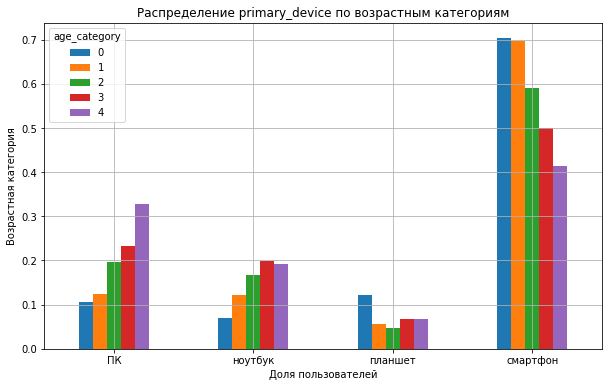

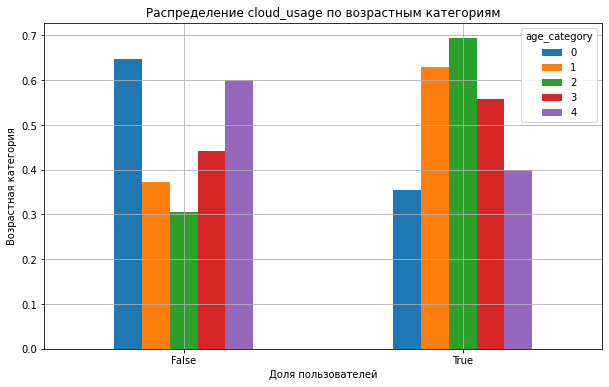

In [19]:
for column in cat_features:
    grouped = df.groupby('age_category')[column].value_counts(normalize=True).unstack(fill_value=0)
    grouped = grouped.T
    
    grouped.plot(
        kind=('barh' if column == 'website_category' else 'bar'),
        rot=0,
        title=f'Распределение {column} по возрастным категориям',
        figsize=((10, 30) if column == 'website_category' else (10, 6))
    )
    
    plt.xlabel('Доля пользователей')
    plt.ylabel(column if column == 'website_category' else 'Возрастная категория')
    plt.grid()
    plt.show()

Исходня из визуального анализа распределения категориальных признаков можно сделать некоторые выводы:

- Большая часть пользователей младше 18 и старше 56 лет редко взаиодействуют с рекламой, в остальных возрастных категориях преобладают пользователи с умеренным взаимодействием с рекламой.
- Большая часть пользователей младше 18 и старше 56 лет имеют низкую глубину просмотра сайтов, у остальных категорий в основном средняя глубина просмотра.
- У всех возрастных категорий преобладающим устройством является смартфон.
- Большая часть пользователей младше 18 и старше 56 лет не пользуются облачными сервисами, у остальных категорий наоборот.

Проанализируем числовые признаки.

In [20]:
def show_features_distribution (df, columns):
    for column in columns:
        print(f'Статистические данные параметра {column}')
        print()
        print(df[column].describe(percentiles=[0.25, 0.5, 0.75, 0.99]))
        print('')
        
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        df.boxplot(column=column, vert=False, ax=axs[0])
        axs[0].set_title(f'Распределение параметра {column}')
        axs[0].set_xlabel('Размер, мм')

        sns.histplot(df[column], kde=True, bins=37, color='skyblue', edgecolor='black')
        axs[1].set_title(f'Распределение параметра {column}')
        axs[1].set_xlabel(column)
        axs[1].set_ylabel('Количество')
        axs[1].grid()

        plt.show()

        print('')

Статистические данные параметра Category 01

count   6146.000000
mean       0.050088
std        0.031304
min        0.000000
25%        0.026786
50%        0.048932
75%        0.069644
99%        0.132298
max        0.180723
Name: Category 01, dtype: float64



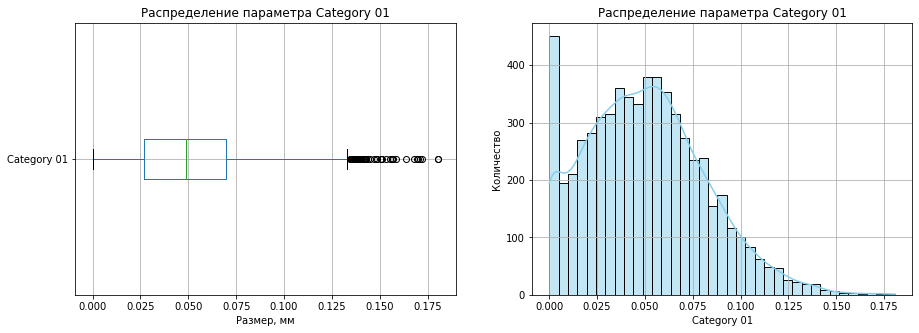


Статистические данные параметра Category 02

count   6146.000000
mean       0.041562
std        0.029449
min        0.000000
25%        0.018519
50%        0.039474
75%        0.060773
99%        0.117770
max        0.182432
Name: Category 02, dtype: float64



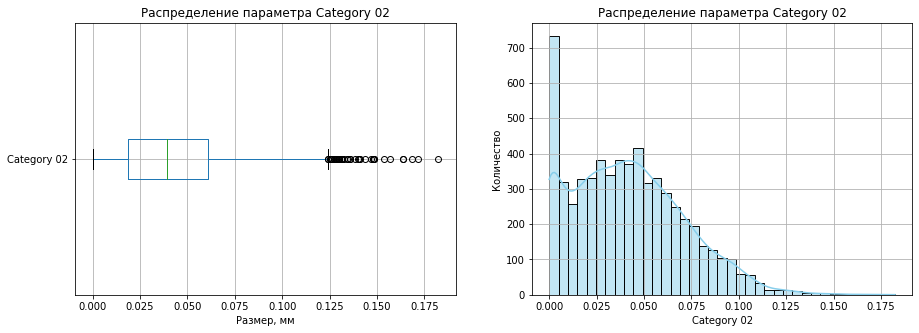


Статистические данные параметра Category 03

count   6146.000000
mean       0.065851
std        0.052098
min        0.000000
25%        0.020243
50%        0.060976
75%        0.101672
99%        0.201676
max        0.259740
Name: Category 03, dtype: float64



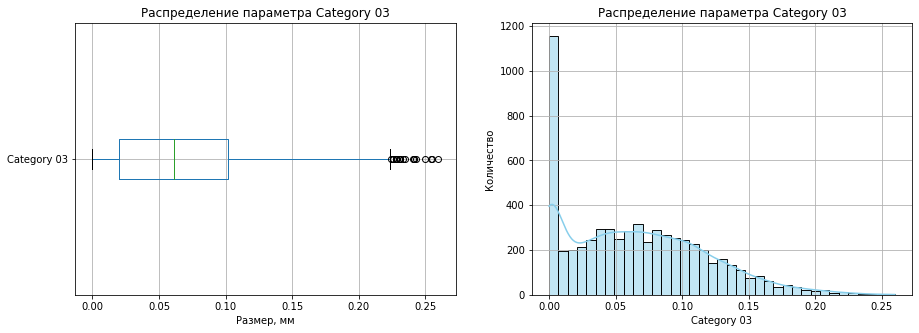


Статистические данные параметра Category 04

count   6146.000000
mean       0.048589
std        0.027912
min        0.000000
25%        0.029126
50%        0.046091
75%        0.066116
99%        0.127451
max        0.186275
Name: Category 04, dtype: float64



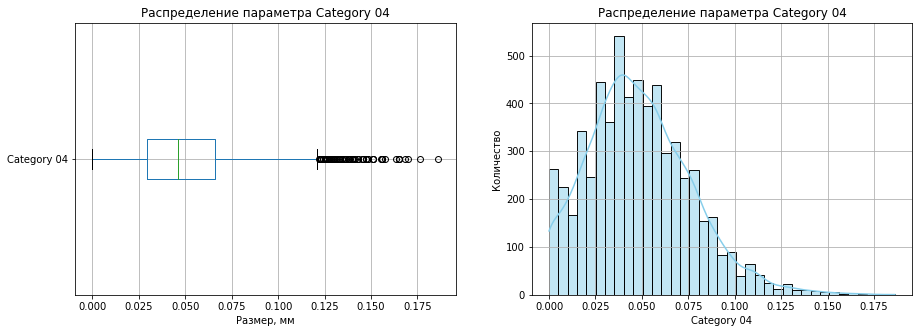


Статистические данные параметра Category 05

count   6146.000000
mean       0.057023
std        0.029543
min        0.000000
25%        0.036519
50%        0.055276
75%        0.075676
99%        0.133333
max        0.176871
Name: Category 05, dtype: float64



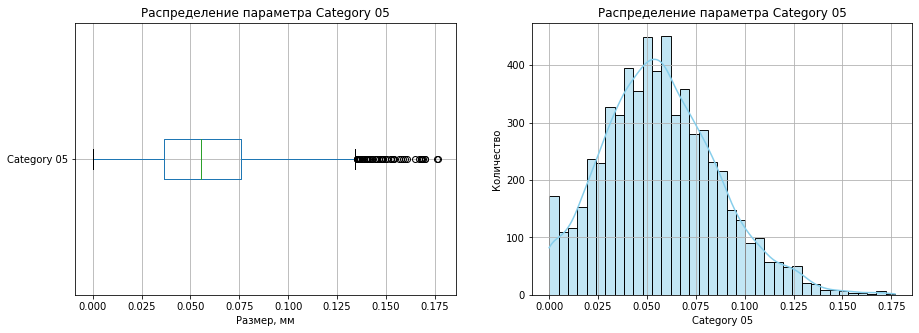


Статистические данные параметра Category 06

count   6146.000000
mean       0.053611
std        0.028024
min        0.000000
25%        0.033919
50%        0.051188
75%        0.070866
99%        0.128780
max        0.174757
Name: Category 06, dtype: float64



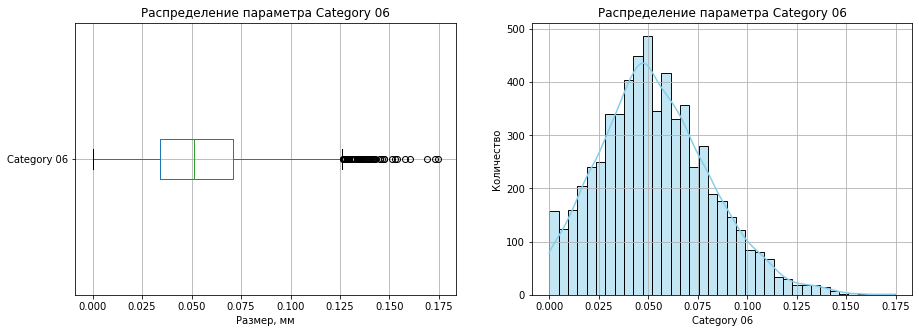


Статистические данные параметра Category 07

count   6146.000000
mean       0.051556
std        0.029371
min        0.000000
25%        0.029851
50%        0.050000
75%        0.069983
99%        0.126506
max        0.176471
Name: Category 07, dtype: float64



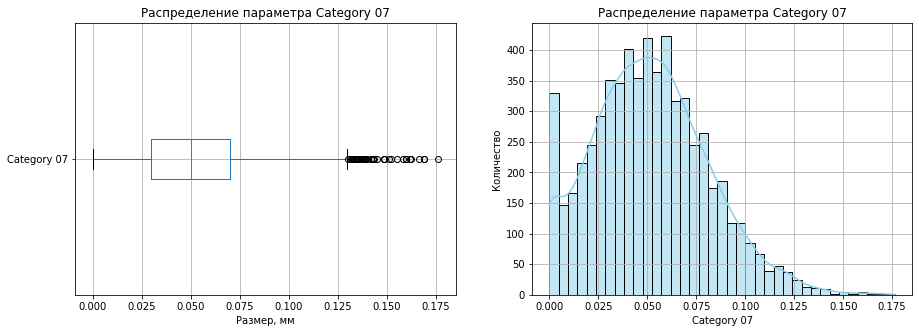


Статистические данные параметра Category 08

count   6146.000000
mean       0.052700
std        0.032174
min        0.000000
25%        0.029126
50%        0.050878
75%        0.074252
99%        0.137426
max        0.192661
Name: Category 08, dtype: float64



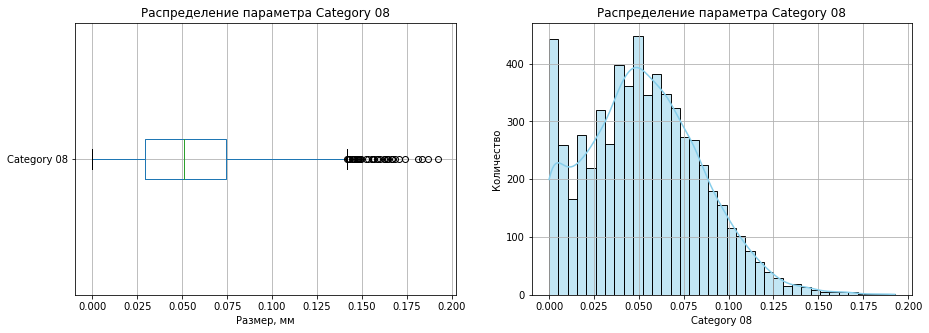


Статистические данные параметра Category 09

count   6146.000000
mean       0.050890
std        0.028304
min        0.000000
25%        0.030515
50%        0.049020
75%        0.068627
99%        0.126877
max        0.190083
Name: Category 09, dtype: float64



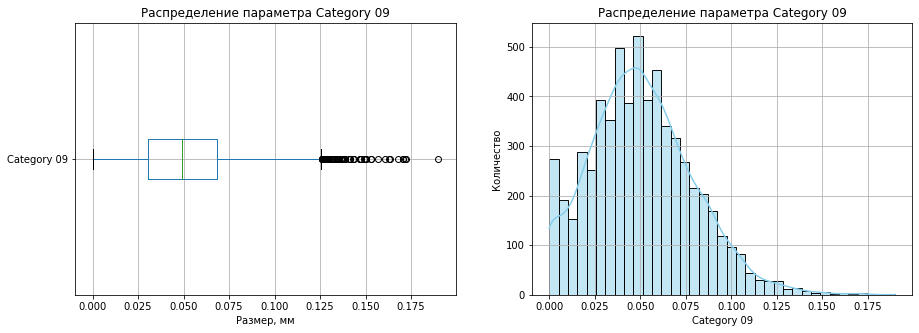


Статистические данные параметра Category 10

count   6146.000000
mean       0.049308
std        0.028787
min        0.000000
25%        0.029126
50%        0.047619
75%        0.067138
99%        0.126645
max        0.225490
Name: Category 10, dtype: float64



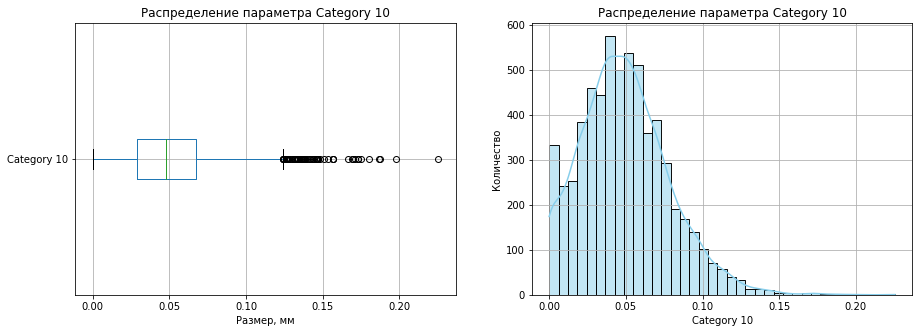


Статистические данные параметра Category 11

count   6146.000000
mean       0.036865
std        0.027044
min        0.000000
25%        0.015873
50%        0.033784
75%        0.054348
99%        0.112996
max        0.171429
Name: Category 11, dtype: float64



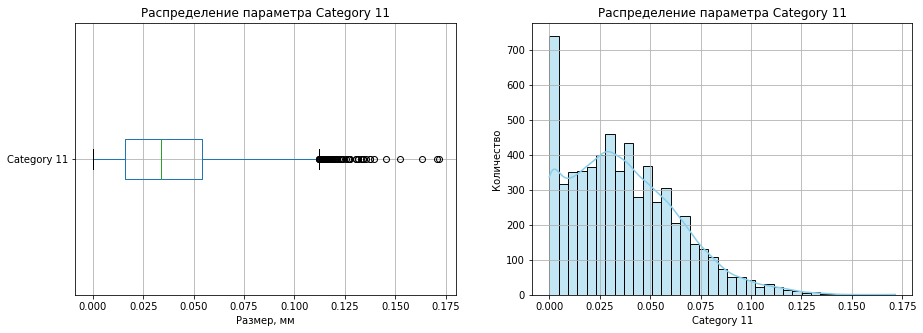


Статистические данные параметра Category 12

count   6146.000000
mean       0.047701
std        0.030470
min        0.000000
25%        0.024691
50%        0.046186
75%        0.067961
99%        0.125828
max        0.177305
Name: Category 12, dtype: float64



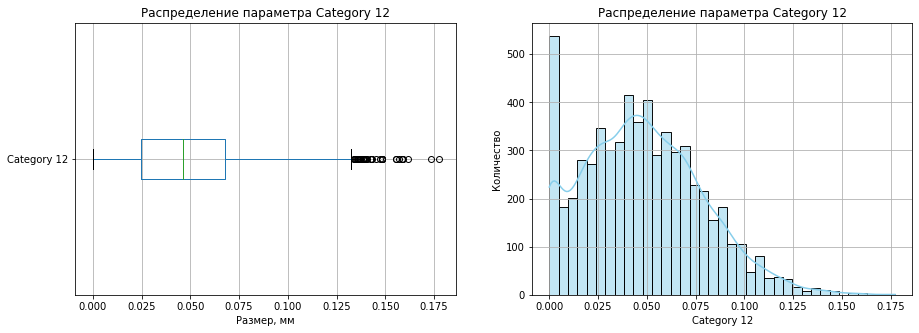


Статистические данные параметра Category 13

count   6146.000000
mean       0.064380
std        0.057232
min        0.000000
25%        0.008065
50%        0.056864
75%        0.103448
99%        0.215561
max        0.293919
Name: Category 13, dtype: float64



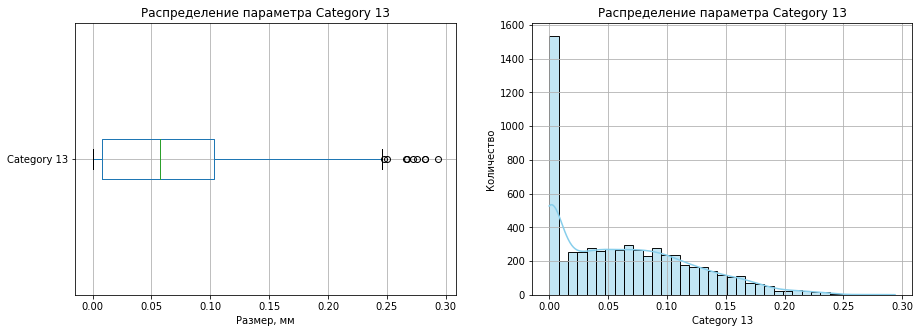


Статистические данные параметра Category 14

count   6146.000000
mean       0.043292
std        0.029835
min        0.000000
25%        0.019737
50%        0.041050
75%        0.063054
99%        0.120120
max        0.188119
Name: Category 14, dtype: float64



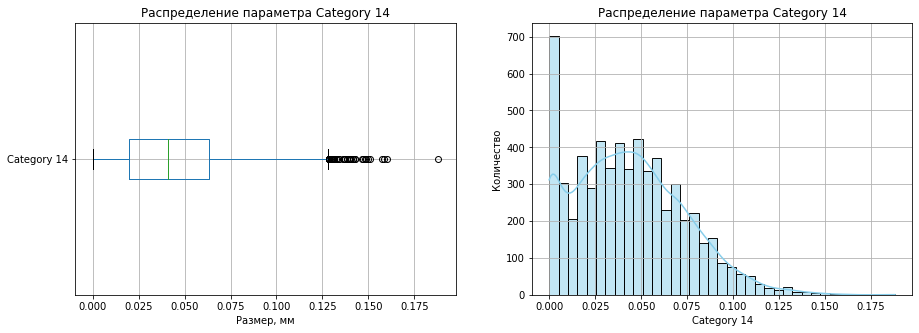


Статистические данные параметра Category 15

count   6146.000000
mean       0.048568
std        0.028624
min        0.000000
25%        0.028571
50%        0.047553
75%        0.067308
99%        0.123529
max        0.205882
Name: Category 15, dtype: float64



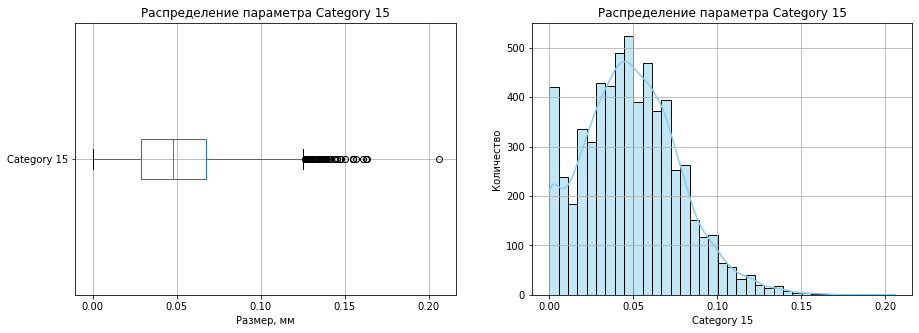


Статистические данные параметра Category 16

count   6146.000000
mean       0.043208
std        0.028440
min        0.000000
25%        0.021436
50%        0.040594
75%        0.060297
99%        0.121410
max        0.160000
Name: Category 16, dtype: float64



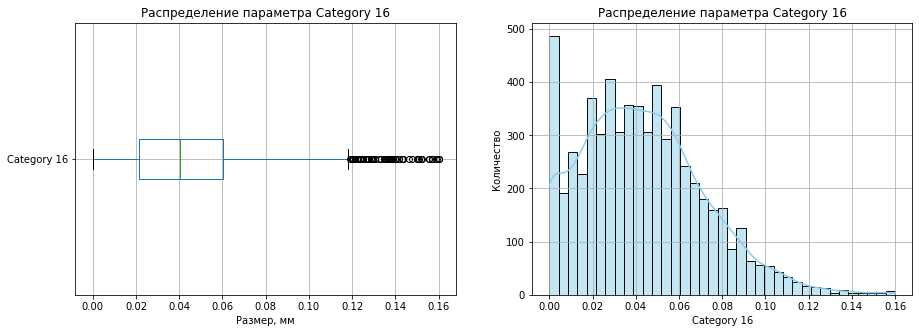


Статистические данные параметра Category 17

count   6146.000000
mean       0.047082
std        0.029277
min        0.000000
25%        0.025424
50%        0.045161
75%        0.065322
99%        0.123788
max        0.185185
Name: Category 17, dtype: float64



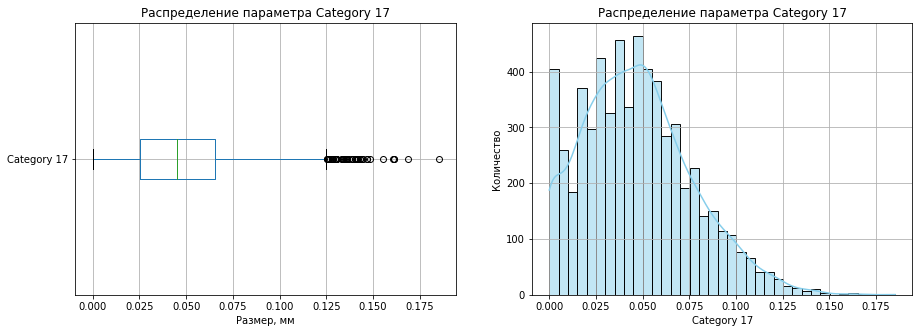


Статистические данные параметра Category 18

count   6146.000000
mean       0.047990
std        0.031831
min        0.000000
25%        0.024590
50%        0.044444
75%        0.067525
99%        0.135545
max        0.206349
Name: Category 18, dtype: float64



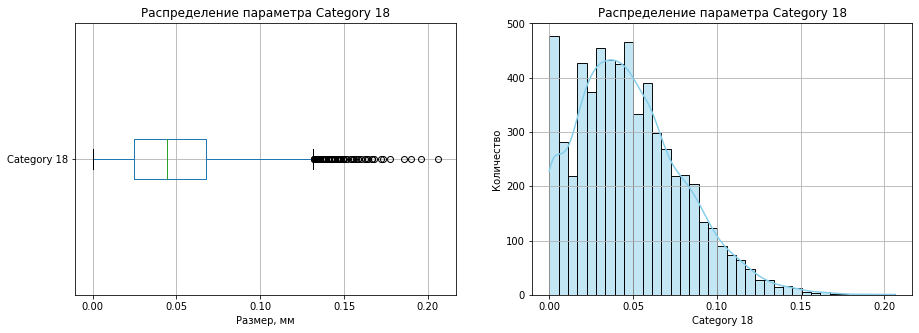


Статистические данные параметра Category 19

count   6146.000000
mean       0.051929
std        0.028793
min        0.000000
25%        0.030844
50%        0.050000
75%        0.070000
99%        0.127451
max        0.188119
Name: Category 19, dtype: float64



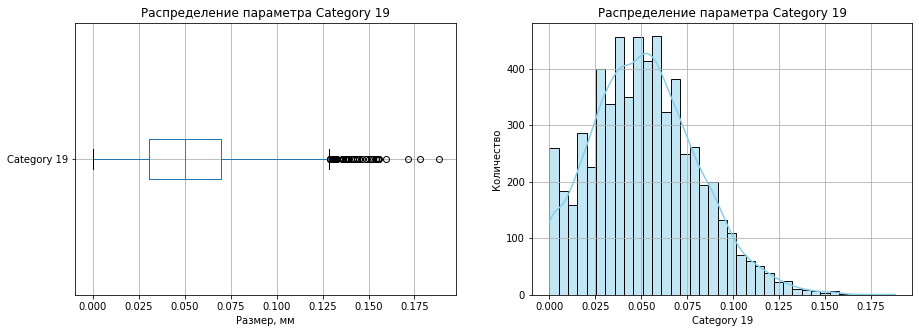


Статистические данные параметра Category 20

count   6146.000000
mean       0.047807
std        0.029192
min        0.000000
25%        0.026490
50%        0.045226
75%        0.066667
99%        0.126174
max        0.182171
Name: Category 20, dtype: float64



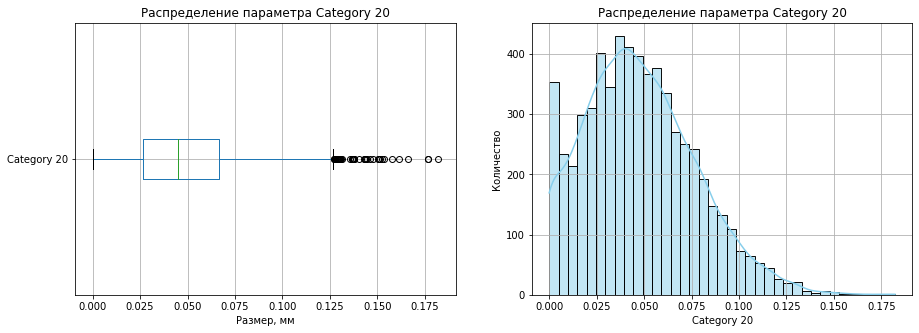


Статистические данные параметра вечер

count   6146.000000
mean       0.358038
std        0.049246
min        0.215517
25%        0.323529
50%        0.357579
75%        0.392157
99%        0.475138
max        0.532468
Name: вечер, dtype: float64



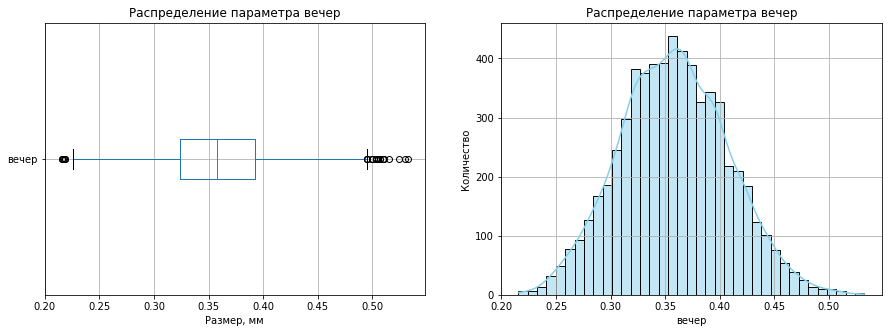


Статистические данные параметра день

count   6146.000000
mean       0.365067
std        0.045316
min        0.217822
25%        0.335173
50%        0.365433
75%        0.395918
99%        0.468962
max        0.536364
Name: день, dtype: float64



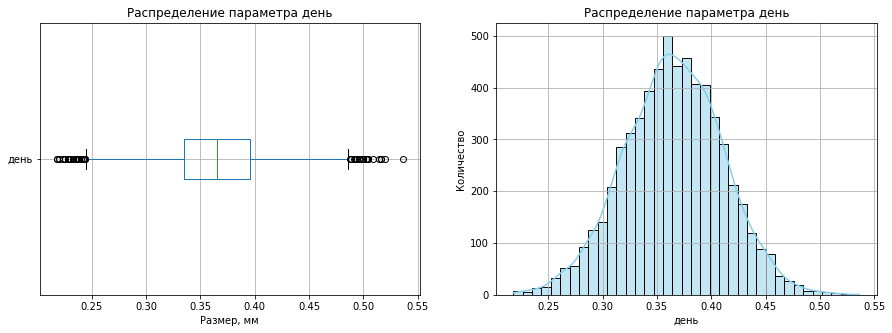


Статистические данные параметра ночь

count   6146.000000
mean       0.078047
std        0.024656
min        0.000000
25%        0.060606
50%        0.076233
75%        0.093519
99%        0.142857
max        0.198020
Name: ночь, dtype: float64



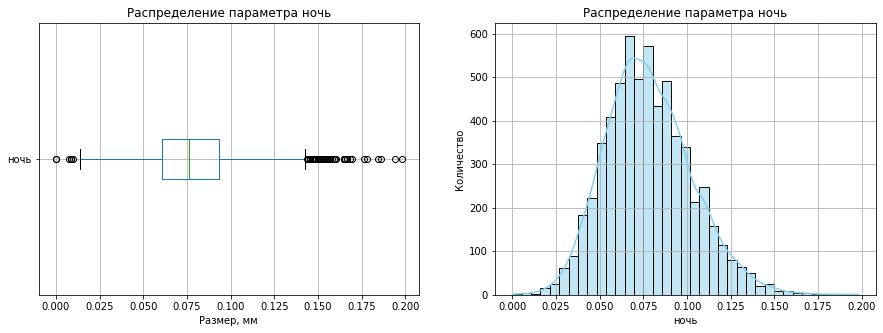


Статистические данные параметра утро

count   6146.000000
mean       0.198848
std        0.038285
min        0.049020
25%        0.172414
50%        0.196765
75%        0.224138
99%        0.292265
max        0.356436
Name: утро, dtype: float64



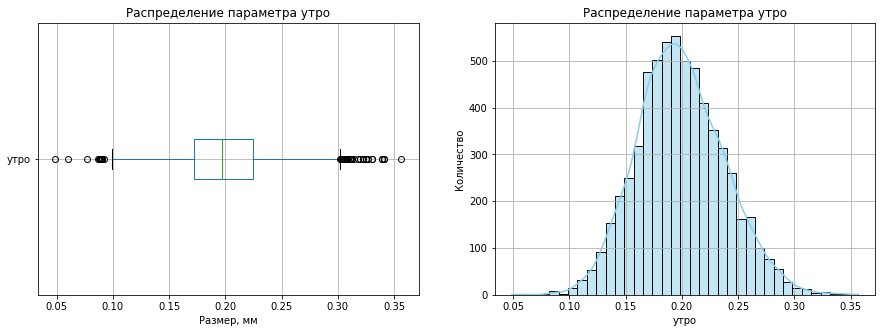

In [21]:
show_features_distribution(df, num_features)

Гисторграммы по данным интернет-активности пользователя в контексте посещения сайтов разных категорий в основном симметричны в своей центральной части, но не являются нормальными в целом. Имеют левостороннюю усеченность и умеренно тяжелый правый хвост.

Гистограммы по признакам `утро`, `день`, `вечер` и `ночь` показывают нормальное распределение.

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'>Хорошая работа в части исследования данных: молодец, что используешь функции, а также применяешь подходящие для типов данных инструменты.</font>

### Корреляция между признаками

Построим матрицу корреялии между признаками.

In [22]:
corr_columns = np.concatenate((cat_features, num_features, ['age_category']))

In [23]:
# Вычисляем корреляционную матрицу с использованием phi_k
correlation_matrix = df[corr_columns].phik_matrix()
correlation_matrix

interval columns not set, guessing: ['Category 01', 'Category 02', 'Category 03', 'Category 04', 'Category 05', 'Category 06', 'Category 07', 'Category 08', 'Category 09', 'Category 10', 'Category 11', 'Category 12', 'Category 13', 'Category 14', 'Category 15', 'Category 16', 'Category 17', 'Category 18', 'Category 19', 'Category 20', 'вечер', 'день', 'ночь', 'утро', 'age_category']


,ads_activity,surf_depth,primary_device,cloud_usage,Category 01,Category 02,Category 03,Category 04,Category 05,Category 06,Category 07,Category 08,Category 09,Category 10,Category 11,Category 12,Category 13,Category 14,Category 15,Category 16,Category 17,Category 18,Category 19,Category 20,вечер,день,ночь,утро,age_category
ads_activity,1.000000,0.024500,0.000000,0.077720,0.079359,0.105505,0.084022,0.051099,0.112791,0.067205,0.091717,0.090976,0.075866,0.126644,0.089730,0.113780,0.081590,0.061998,0.087305,0.145146,0.073504,0.130450,0.070558,0.085972,0.152503,0.158099,0.161873,0.182412,0.373374
surf_depth,0.024500,1.000000,0.000000,0.020270,0.000000,0.052071,0.000000,0.009335,0.044291,0.000000,0.081554,0.046776,0.000000,0.069520,0.040212,0.002729,0.040980,0.012268,0.103265,0.012980,0.057361,0.065156,0.020861,0.000000,0.065669,0.018900,0.000000,0.061337,0.143816
primary_device,0.000000,0.000000,1.000000,0.000000,0.062942,0.054516,0.058228,0.035485,0.000000,0.000000,0.069993,0.000000,0.100287,0.029609,0.063459,0.063181,0.104408,0.093266,0.058402,0.047836,0.079819,0.046216,0.050790,0.074963,0.136811,0.120025,0.110376,0.123364,0.184037
cloud_usage,0.077720,0.020270,0.000000,1.000000,0.054425,0.133654,0.035098,0.081784,0.062160,0.063191,0.119273,0.068451,0.077154,0.055532,0.088024,0.036113,0.126455,0.023895,0.041616,0.098901,0.111325,0.097160,0.037827,0.043937,0.120285,0.098283,0.053133,0.102951,0.214836
Category 01,0.079359,0.000000,0.062942,0.054425,1.000000,0.123240,0.312296,0.282944,0.078886,0.218171,0.214542,0.184362,0.081364,0.104520,0.122976,0.147153,0.476569,0.154995,0.054508,0.178182,0.079776,0.272688,0.072830,0.066654,0.129168,0.058983,0.059418,0.124252,0.263219
Category 02,0.105505,0.052071,0.054516,0.133654,0.123240,1.000000,0.426141,0.088493,0.141835,0.127990,0.162539,0.224341,0.122427,0.068270,0.230106,0.183987,0.171338,0.332523,0.099373,0.138870,0.086007,0.196191,0.213788,0.108441,0.166990,0.084331,0.127559,0.153752,0.410441
Category 03,0.084022,0.000000,0.058228,0.035098,0.312296,0.426141,1.000000,0.173869,0.050912,0.297002,0.107019,0.271899,0.118319,0.098711,0.240470,0.260813,0.182275,0.357354,0.055714,0.124812,0.350964,0.157986,0.237881,0.152121,0.107035,0.052332,0.073200,0.050629,0.380718
Category 04,0.051099,0.009335,0.035485,0.081784,0.282944,0.088493,0.173869,1.000000,0.178574,0.151183,0.214449,0.174823,0.090029,0.105246,0.158939,0.172190,0.281657,0.061718,0.051153,0.078797,0.084623,0.111034,0.152051,0.136405,0.061807,0.050392,0.066587,0.058457,0.415840
Category 05,0.112791,0.044291,0.000000,0.062160,0.078886,0.141835,0.050912,0.178574,1.000000,0.123069,0.231983,0.153959,0.072274,0.321858,0.164165,0.191660,0.091760,0.129556,0.218326,0.116702,0.245082,0.131622,0.283430,0.152181,0.131250,0.057921,0.000000,0.084899,0.320405
Category 06,0.067205,0.000000,0.000000,0.063191,0.218171,0.127990,0.297002,0.151183,0.123069,1.000000,0.133253,0.133205,0.151748,0.158165,0.093965,0.182003,0.045646,0.110948,0.094993,0.114214,0.167188,0.126762,0.146319,0.121632,0.142654,0.117886,0.109935,0.129553,0.306705


Визуализируем корреляцию с помощью тепловой карты.

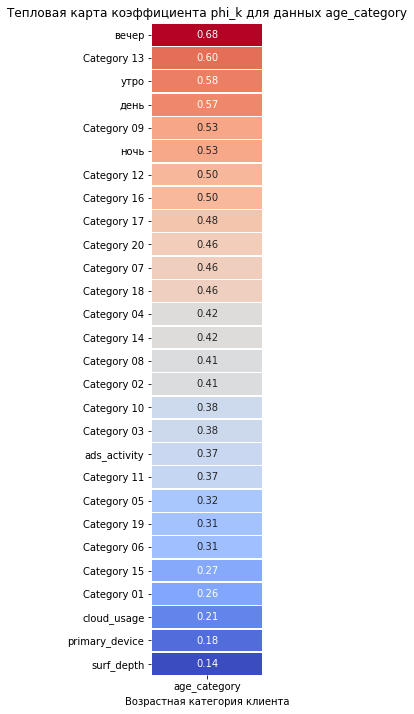

In [24]:
plt.figure(figsize=(2, 12))
data_heatmap = correlation_matrix.loc[correlation_matrix.index != 'age_category'][['age_category']].sort_values(by='age_category', ascending=False)
sns.heatmap(data_heatmap,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    linewidths=0.5,
    cbar=False
)
plt.title('Тепловая карта коэффициента phi_k для данных age_category')
plt.xlabel('Возрастная категория клиента')
plt.show()

Большая часть признаков имеют умеренную связь с целевой переменной. Наибольшая связь у признака `вечер` - 0.68. Признаки `Category 15`, `Category 01`, `cloud_usage`, `primary_device` и `surf_depth` имеют слабую связь с целевой переменной.

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'>Здорово,что применена `phik` для анализа и нелинейных зависимостей</font>

## Предобработка данных

Разделим данные на две части: для обучения (train) и тестовую (test) в соотношении 70:30.

In [25]:
X = df.drop(columns = ['age_category'])
y = df['age_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ⚠️\
<span style="color: darkorange"> Не совсем понятно, зачем нам три выборки. Подбор параметров и оцеку моделей мы проводим кросс-валидацией.</span>

<span style="color: purple; font-weight: bold">Комментарий студента</span>:<br />
Поправил.

<span style="color: blue; font-weight: bold">Комментарий ревьюера 2: </span> ✔️\
<span style="color: green"> 👍</span>

Проверим пропорции.

In [26]:
print("Размер выборки для обучения:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер выборки для обучения: (4302, 28)
Размер тестовой выборки: (1844, 28)


In [27]:
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
])

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
])

cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [28]:
def build_preprocessor(cat_features, num_features):
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', cat_pipeline, cat_features),
            ('num', num_pipeline, num_features)
        ]
    )
    return preprocessor

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green"> 👍</span>

In [29]:
# Создаем ColumnTransformer
preprocessor = build_preprocessor(cat_features, num_features)

# Предварительный fit() для получения имён признаков
X_train_processed = preprocessor.fit_transform(X_train, y_train)
feature_names = preprocessor.get_feature_names_out()

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span>  ❌\
<span style="color: red"> ~~Препроцессор (да и что бы то ни было), нельзя обучать на валидационных данных. Метод fit только для train выборки.~~ </span>

<span style="color: purple; font-weight: bold">Комментарий студента</span>:<br />
Поправил.

<span style="color: blue; font-weight: bold">Комментарий ревьюера 2: </span> ✔️\
<span style="color: green"> 👍</span>

In [30]:
def select_features(X_transformed, indices):
    return X_transformed[:, indices]

In [31]:
def build_pipeline(X, preprocessor, model, selected_features, scoring=None):
    feature_names_all = list(preprocessor.get_feature_names_out())
    selected_indices = [feature_names_all.index(f) for f in selected_features]

    selector = FunctionTransformer(
        select_features, 
        validate=False,
        kw_args={'indices': selected_indices}
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('selector', selector),
        ('model', model)
    ])
    
    if scoring is None:
        scoring = {
            'f1_macro': make_scorer(f1_score, average='macro'),
            'precision_macro': make_scorer(precision_score, average='macro'),
            'recall_macro': make_scorer(recall_score, average='macro')
        }

    cv_results = cross_validate(
        pipeline,
        X=X,
        y=y_train, 
        scoring=scoring, 
        cv=cv_splitter, 
        n_jobs=-1,
        return_estimator=True
    )
    return pipeline, cv_results

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green">Верно, что применяется F1 macro.</span>

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span>  ❌\
<span style="color: red"> ~~Кросс-валидация проводится на обучающих данных.~~ </span>

<span style="color: purple; font-weight: bold">Комментарий студента</span>:<br />
Поправил.

<span style="color: blue; font-weight: bold">Комментарий ревьюера 2: </span> ✔️\
<span style="color: green"> 👍</span>

## Обучение и оценка базовой модели

Обучим базовую модель DummyClassifier.

In [32]:
dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

In [33]:
print(f"F1: {f1_score(y_test, y_pred_dummy, average='macro'):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_dummy, average='macro', zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_dummy, average='macro'):.4f}")

F1: 0.0937
Precision: 0.0612
Recall: 0.2000


Обучим базовую модель LogisticRegression.

In [34]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced', solver="lbfgs", penalty="l2", random_state=RANDOM_STATE)
lr_pipeline, lr_cv_results = build_pipeline(X_train, preprocessor, lr, feature_names)

Посмотрим на метрики модели LogisticRegression.

In [35]:
print(f"F1: {lr_cv_results['test_f1_macro'].mean():.4f}")
print(f"Precision: {lr_cv_results['test_precision_macro'].mean():.4f}")
print(f"Recall: {lr_cv_results['test_recall_macro'].mean():.4f}")

F1: 0.8075
Precision: 0.8025
Recall: 0.8174


<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green"> 👍</span>

Обучим базовые модели SVC на разных ядрах.

In [36]:
svc_linear = SVC(
    class_weight='balanced',
    kernel='linear',
    random_state=RANDOM_STATE,
)

svc_poly = SVC(
    class_weight='balanced',
    kernel='poly',
    degree=3,
    coef0=1,
    random_state=RANDOM_STATE,
)

svc_rbf = SVC(
    class_weight='balanced',
    kernel='rbf',
    gamma='scale',
    random_state=RANDOM_STATE
)

svc_sigmoid = SVC(
    class_weight='balanced',
    kernel='sigmoid',
    coef0=1,
    gamma='scale',
    random_state=RANDOM_STATE
)

svc_scores = {}

_, svc_scores['linear'] = build_pipeline(X_train, preprocessor, svc_linear, feature_names)
_, svc_scores['poly'] = build_pipeline(X_train, preprocessor, svc_poly, feature_names)
_, svc_scores['rbf'] = build_pipeline(X_train, preprocessor, svc_rbf, feature_names)
_, svc_scores['sigmoid'] = build_pipeline(X_train, preprocessor, svc_sigmoid, feature_names)

Посмотрим на метрики SVC моделей.

In [37]:
for name, metrics in svc_scores.items():
    print(f"Ядро: {name}")
    print("Средние значения метрик:")
    print(f"F1: {metrics['test_f1_macro'].mean():.4f}")
    print(f"Precision: {metrics['test_precision_macro'].mean():.4f}")
    print(f"Recall: {metrics['test_recall_macro'].mean():.4f}")
    print("-" * 50)

Ядро: linear
Средние значения метрик:
F1: 0.8117
Precision: 0.8045
Recall: 0.8258
--------------------------------------------------
Ядро: poly
Средние значения метрик:
F1: 0.8942
Precision: 0.8923
Recall: 0.8969
--------------------------------------------------
Ядро: rbf
Средние значения метрик:
F1: 0.8978
Precision: 0.8923
Recall: 0.9052
--------------------------------------------------
Ядро: sigmoid
Средние значения метрик:
F1: 0.5564
Precision: 0.5616
Recall: 0.5624
--------------------------------------------------


Среди базовых моделей SVC модель с `linear` ядром показывает лучшие результаты, близкие к результатам модели LogisticRegression, но в целом результаты низкие.

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green"> 👍</span>

## Создание и отбор признаков

Напишем функцию для создания новых признаков.

In [38]:
def create_enhanced_features(X):
    """
    Создаёт расширенный набор признаков
    """

    # Создаём копию датасета, чтобы не изменять исходный датасет
    X_enhanced = X.copy()

    # 1. # Мобильные облачные пользователи
    X_enhanced['mobile_cloud_user'] = ((X_enhanced['primary_device'] == 'смартфон') & 
                               (X_enhanced['cloud_usage'] == True)).astype(int)
    
    # 2. Активные пользователи рекламы
    active_ads = ['умеренно', 'часто', 'очень часто']
    X_enhanced['is_active_ads_user'] = X_enhanced['ads_activity'].isin(active_ads).astype(int)
    
    # Удаляем исходные признаки, которые заменили производными
    columns_to_drop = []

    # Удаляем указанные колонки
    X_enhanced = X_enhanced.drop(columns=columns_to_drop)

    return X_enhanced

# Создаем расширенный набор признаков
X_train_enhanced = create_enhanced_features(X_train)

In [39]:
X_train_enhanced.head()

,Category 01,Category 02,Category 03,Category 04,Category 05,Category 06,Category 07,Category 08,Category 09,Category 10,Category 11,Category 12,Category 13,Category 14,Category 15,Category 16,Category 17,Category 18,Category 19,Category 20,вечер,день,ночь,утро,ads_activity,surf_depth,primary_device,cloud_usage,mobile_cloud_user,is_active_ads_user
5918,0.067227,0.046218,0.079832,0.100840,0.000000,0.058824,0.058824,0.029412,0.058824,0.033613,0.046218,0.063025,0.042017,0.071429,0.050420,0.058824,0.012605,0.054622,0.046218,0.021008,0.403361,0.344538,0.050420,0.201681,редко,средне,смартфон,True,1,0
5236,0.084416,0.000000,0.155844,0.038961,0.064935,0.025974,0.058442,0.045455,0.090909,0.038961,0.032468,0.038961,0.064935,0.000000,0.058442,0.032468,0.058442,0.038961,0.032468,0.038961,0.311688,0.363636,0.071429,0.253247,редко,поверхностно,смартфон,True,1,0
4297,0.107143,0.035714,0.026786,0.000000,0.089286,0.035714,0.044643,0.098214,0.035714,0.053571,0.035714,0.044643,0.035714,0.071429,0.000000,0.071429,0.107143,0.044643,0.000000,0.062500,0.330357,0.375000,0.044643,0.250000,редко,поверхностно,смартфон,True,1,0
1568,0.034682,0.109827,0.000000,0.052023,0.052023,0.080925,0.046243,0.063584,0.034682,0.034682,0.028902,0.046243,0.028902,0.075145,0.034682,0.069364,0.069364,0.046243,0.017341,0.075145,0.375723,0.323699,0.098266,0.202312,умеренно,средне,смартфон,True,1,1
1490,0.059259,0.037037,0.103704,0.074074,0.029630,0.044444,0.059259,0.044444,0.044444,0.044444,0.044444,0.044444,0.000000,0.014815,0.014815,0.022222,0.096296,0.111111,0.088889,0.022222,0.318519,0.318519,0.051852,0.311111,очень редко,поверхностно,смартфон,False,0,0


Применим методы-обёртки для отбора признаков.

In [40]:
cat_features_enhanced = X_train_enhanced.select_dtypes(include=['object']).columns

num_features_enhanced = X_train_enhanced.select_dtypes(include=['int', 'float']).columns
num_features_enhanced = num_features_enhanced.drop(['age_category'], errors='ignore').tolist()

# Создаем ColumnTransformer
preprocessor_enhanced = build_preprocessor(cat_features_enhanced, num_features_enhanced)

X_train_enhanced_processed = preprocessor_enhanced.fit_transform(X_train_enhanced, y_train)
feature_names_enhanced = preprocessor_enhanced.get_feature_names_out()

In [41]:
# Инициализируем модель, которая будет использоваться для оценки важности признаков
lr_estimator = LogisticRegression(max_iter=1000, solver="lbfgs", penalty="l2", random_state=RANDOM_STATE)

# Создаём объект RFE
rfe_selector = RFE(lr_estimator, n_features_to_select=30)

# Обучаем RFE
rfe_selector.fit(X_train_enhanced_processed, y_train)

# Получаем информацию о выбранных признаках
rfe_selected_idx = rfe_selector.support_
selected_rfe_features = np.array(feature_names_enhanced)[rfe_selected_idx]

In [42]:
print('Выбранные признаки:')
selected_rfe_features.tolist()

Выбранные признаки:


['cat__ads_activity_очень редко',
 'cat__ads_activity_очень часто',
 'cat__ads_activity_умеренно',
 'cat__ads_activity_часто',
 'cat__surf_depth_поверхностно',
 'cat__primary_device_ПК',
 'cat__primary_device_ноутбук',
 'cat__primary_device_планшет',
 'cat__cloud_usage_True',
 'num__Category 02',
 'num__Category 03',
 'num__Category 04',
 'num__Category 06',
 'num__Category 07',
 'num__Category 08',
 'num__Category 09',
 'num__Category 10',
 'num__Category 12',
 'num__Category 13',
 'num__Category 14',
 'num__Category 15',
 'num__Category 16',
 'num__Category 17',
 'num__Category 18',
 'num__Category 19',
 'num__Category 20',
 'num__вечер',
 'num__день',
 'num__ночь',
 'num__утро']

In [43]:
lr_pipeline_enhanced, lr_cv_results_enhanced = build_pipeline(X_train_enhanced, preprocessor_enhanced, lr, selected_rfe_features)

Посмотрим на метрики модели LogisticRegression с добавленными признаками.

In [44]:
print(f"F1: {lr_cv_results_enhanced['test_f1_macro'].mean():.4f}")
print(f"Precision: {lr_cv_results_enhanced['test_precision_macro'].mean():.4f}")
print(f"Recall: {lr_cv_results_enhanced['test_recall_macro'].mean():.4f}")
print()
print(f"Изменение метрики F1: {(lr_cv_results_enhanced['test_f1_macro'].mean() - lr_cv_results['test_f1_macro'].mean()):.4f}")
print(f"Изменение метрики Precision: {(lr_cv_results_enhanced['test_precision_macro'].mean() - lr_cv_results['test_precision_macro'].mean()):.4f}")
print(f"Изменение метрики Recall: {(lr_cv_results_enhanced['test_recall_macro'].mean() - lr_cv_results['test_recall_macro'].mean()):.4f}")

F1: 0.8018
Precision: 0.7967
Recall: 0.8119

Изменение метрики F1: -0.0056
Изменение метрики Precision: -0.0058
Изменение метрики Recall: -0.0055


После добавления новых признаков и отбора метрики улучшились но незначительно.

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green"> 👍</span>

## Подбор гиперпараметров моделей

Создадим сетку гиперпараметров для модели LogisticRegression и SVC моделей с учётом специфики ядер.

In [45]:
lr_param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__max_iter': [500, 1000, 5000],
    'model__tol': [1e-4, 1e-3, 1e-2]
}

svc_param_grid = [
    {
        "model__kernel": ["linear"],
        "model__C": [0.01, 0.1, 1],
        "model__class_weight": ['balanced']
    },
    {
        "model__kernel": ["poly"],
        "model__C": [0.01, 0.1, 1],
        "model__gamma": ["scale", "auto"],
        "model__degree": [2, 3, 4],
        "model__coef0": [0.0, 1.0],
        "model__class_weight": ['balanced']
    },
    {
        "model__kernel": ["rbf"],
        "model__C": [0.01, 0.1, 1],
        "model__gamma": ["scale", "auto"],
        "model__class_weight": ['balanced']
    },
    {
        "model__kernel": ["sigmoid"],
        "model__C": [0.01, 0.1, 1],
        "model__gamma": ["scale", "auto"],
        "model__coef0": [0.0, 1.0],
        "model__class_weight": ['balanced']
    }
]

Сделаем поиск лучших гиперпараметров.

In [46]:
lr_grid = GridSearchCV(
    estimator=lr_pipeline_enhanced,
    param_grid=lr_param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

svc = SVC(class_weight='balanced', random_state=RANDOM_STATE)
svc_pipeline, svc_cv_results = build_pipeline(X_train_enhanced, preprocessor_enhanced, svc, selected_rfe_features)
svc_grid = GridSearchCV(
    estimator=svc_pipeline,
    param_grid=svc_param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

Определим лучшие гиперпараметры.

In [47]:
lr_grid.fit(X_train_enhanced, y_train)

lr_best_params = lr_grid.best_params_
lr_best_params_clean = {k.replace('model__', ''): v 
                     for k, v in lr_best_params.items()}
lr_best_score = round(lr_grid.best_score_, 3)


svc_grid.fit(X_train_enhanced, y_train)

svc_best_params = svc_grid.best_params_
svc_best_params_clean = {k.replace('model__', ''): v 
                     for k, v in svc_best_params.items()}
svc_best_score = round(svc_grid.best_score_, 3)

print()
print("Лучшие гиперпараметры для LogisticRegression:", lr_best_params)
print("Лучший средний результат F1 на кросс-валидации для LogisticRegression:", lr_best_score)
print()
print("Лучшие гиперпараметры для SVC:", svc_best_params)
print("Лучший средний результат F1 на кросс-валидации для SVC:", svc_best_score)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Fitting 3 folds for each of 57 candidates, totalling 171 fits

Лучшие гиперпараметры для LogisticRegression: {'model__C': 0.1, 'model__max_iter': 500, 'model__tol': 0.0001}
Лучший средний результат F1 на кросс-валидации для LogisticRegression: 0.806

Лучшие гиперпараметры для SVC: {'model__C': 1, 'model__class_weight': 'balanced', 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Лучший средний результат F1 на кросс-валидации для SVC: 0.885


Выведем топ-15 лучших гиперпараметров.

In [48]:
lr_results = pd.DataFrame(lr_grid.cv_results_)
svc_results = pd.DataFrame(svc_grid.cv_results_)

lr_results['source'] = 'lr'
svc_results['source'] = 'svc'

combined_results = pd.concat([lr_results, svc_results], ignore_index=True)

top_15 = combined_results.sort_values('mean_test_score', ascending=False).head(15)
top_15[['params', 'mean_test_score']]

,params,mean_test_score
97,"{'model__C': 1, 'model__class_weight': 'balanced', 'model__gamma': 'scale', 'model__kernel': 'rbf'}",0.884608
79,"{'model__C': 0.1, 'model__class_weight': 'balanced', 'model__coef0': 1.0, 'model__degree': 4, 'model__gamma': 'scale', 'model__kernel': 'poly'}",0.882182
98,"{'model__C': 1, 'model__class_weight': 'balanced', 'model__gamma': 'auto', 'model__kernel': 'rbf'}",0.880561
90,"{'model__C': 1, 'model__class_weight': 'balanced', 'model__coef0': 1.0, 'model__degree': 3, 'model__gamma': 'auto', 'model__kernel': 'poly'}",0.880354
89,"{'model__C': 1, 'model__class_weight': 'balanced', 'model__coef0': 1.0, 'model__degree': 3, 'model__gamma': 'scale', 'model__kernel': 'poly'}",0.878470
92,"{'model__C': 1, 'model__class_weight': 'balanced', 'model__coef0': 1.0, 'model__degree': 4, 'model__gamma': 'auto', 'model__kernel': 'poly'}",0.878275
83,"{'model__C': 1, 'model__class_weight': 'balanced', 'model__coef0': 0.0, 'model__degree': 3, 'model__gamma': 'scale', 'model__kernel': 'poly'}",0.878229
87,"{'model__C': 1, 'model__class_weight': 'balanced', 'model__coef0': 1.0, 'model__degree': 2, 'model__gamma': 'scale', 'model__kernel': 'poly'}",0.876610
80,"{'model__C': 0.1, 'model__class_weight': 'balanced', 'model__coef0': 1.0, 'model__degree': 4, 'model__gamma': 'auto', 'model__kernel': 'poly'}",0.876025
91,"{'model__C': 1, 'model__class_weight': 'balanced', 'model__coef0': 1.0, 'model__degree': 4, 'model__gamma': 'scale', 'model__kernel': 'poly'}",0.875799


<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Отлично, что есть табличка результатов для сравнения.</font>

## Подготовка артефактов модели для внедрения

In [49]:
final_model = LogisticRegression(solver="lbfgs", penalty="l2", random_state=RANDOM_STATE, **lr_best_params_clean)

final_pipeline, final_cv_results = build_pipeline(X_train_enhanced, preprocessor_enhanced, final_model, selected_rfe_features)
final_pipeline.fit(X_train_enhanced, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['ads_activity', 'surf_depth', 'primary_device', 'cloud_usage'], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))...
                                                   'Category 19', 'Category 20',
                                                   'вечер', 'день', 'ночь',
                                                   'утро', 'mobile_cloud_user',
                                                   'is_active_ads_user'])])),
                ('selector',
                 FunctionTransformer(func=<function select_features at 0x7ff5bc73a160>,
                                     kw_args={'indices': [0, 1, 3, 4, 6, 8, 9,
                                                          10, 13, 15, 16, 17,
                                                          19, 20, 21, 22, 23,
                                                          25, 26, 27, 28, 29,
                                                          30, 31, 32, 33, 34,
                                                          35, 36, 37]})),
                ('model',
                 LogisticRegression(C=0.1, max_iter=500, random_state=42))])

In [50]:
X_test_enhanced = create_enhanced_features(X_test)

y_pred = final_pipeline.predict(X_test_enhanced)
print("F1:", round(f1_score(y_test, y_pred, average="macro"), 2))
print(classification_report(y_test, y_pred))

F1: 0.82
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       268
           1       0.75      0.60      0.67       161
           2       0.85      0.85      0.85       459
           3       0.83      0.85      0.84       392
           4       0.88      0.90      0.89       564

    accuracy                           0.85      1844
   macro avg       0.83      0.81      0.82      1844
weighted avg       0.84      0.85      0.84      1844



F1 = 0.82 - хороший средний результат, удовлетворяющий требованиям.

<font color='blue'><b>Комментарий ревьюера: </b></font> ❌\
<font color='red'> К сожалению, Лучшая из моделей не показала результат выше 0.75 F1-меры macro на тестовых данных.</font>
> Значение F1-меры лучшей модели должно быть не меньше 0.75 и на кросс-валидации по обучающей выборке, и на тестовой выборке. В этом случае модель можно рекомендовать к внедрению.

<span style="color: purple; font-weight: bold">Комментарий студента</span>:<br />
Можешь подсказать какие еще шаги можно предпринять для повышения. Я пробовал еще добавлять разные признаки, результат примерно такой же остается.

<span style="color: blue; font-weight: bold">Комментарий ревьюера 2: </span> ⚠️\
<span style="color: blue">При формировании датасета данные агрегируются до одного наиболее частого значения, что приводит к потере информации о распределении пользовательского поведения. Нужно "развернуть" пользователя в вектор, добавив каждому пользователю доли активности по категориям и времени суток, как дополнительные признаки. Такой подход сохраняет информацию о распределении действий пользователя и повышает качество обучения модели.</span>


<span style="color: purple; font-weight: bold">Комментарий студента 2</span>:<br />
Большое спасибо! Не думал что эти данные так повлияют на результат.

Сохраним итоговую модель и пайплайн предобработки в файл final_model.joblib.

In [51]:
joblib.dump(final_pipeline, 'final_model.joblib')

['final_model.joblib']

Протестируем сохраненную модель. Загрузим файл и проверим загруженную модель на тестовых данных.

In [52]:
# Загрузим модель из файла 'final_model.joblib' в переменную loaded_model
loaded_model = joblib.load('final_model.joblib')

# Получаем предсказание
prediction = loaded_model.predict(X_test_enhanced)
prediction_proba = loaded_model.predict_proba(X_test_enhanced)

print(prediction)
prediction_proba

[4 2 0 ... 3 0 3]


array([[9.85666832e-02, 1.77343502e-02, 3.32950480e-03, 1.51797278e-02,
        8.65189734e-01],
       [1.33459506e-02, 1.18423739e-02, 8.59125334e-01, 8.89698176e-02,
        2.67165243e-02],
       [9.51276925e-01, 4.83853038e-02, 2.86200887e-04, 1.45795547e-05,
        3.69904364e-05],
       ...,
       [4.03229353e-04, 4.00261527e-05, 1.22403199e-02, 9.87023660e-01,
        2.92764287e-04],
       [9.54601844e-01, 2.37052572e-02, 6.82918198e-03, 1.47767706e-02,
        8.69466913e-05],
       [1.03177007e-05, 2.47357710e-05, 3.14353058e-04, 8.28930928e-01,
        1.70719665e-01]])

Сохраним функцию для объединения данных.

In [53]:
joblib.dump(combine_data, 'combine_data_function.joblib')

['combine_data_function.joblib']

Протестируем сохраненную функцию.

In [54]:
new_df = combine_data(ds_s13_users_df, ds_s13_visits_df, ads_activity_df, surf_depth_df, primary_device_df, cloud_usage_df)

<span style="color: blue; font-weight: bold">Комментарий ревьюера 2: </span> ⚠️\
<span style="color: darkorange">В combine_data хорошо бы написать Док-стринг, где прописать, хотя бы, в какой последовательности подавать Датафреймы.
</span>\
[docstrings](https://pyplanet.ru/article/pep-0008.html#section-19:~:text=%23%20%D0%9A%D0%BE%D0%BC%D0%BF%D0%B5%D0%BD%D1%81%D0%B0%D1%86%D0%B8%D1%8F%20%D0%B3%D1%80%D0%B0%D0%BD%D0%B8%D1%86%D1%8B-,%D0%A1%D1%82%D1%80%D0%BE%D0%BA%D0%B8%20%D0%B4%D0%BE%D0%BA%D1%83%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D0%B8,-%D0%A1%D0%BE%D0%B3%D0%BB%D0%B0%D1%88%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%BF%D0%BE%20%D0%BD%D0%B0%D0%BF%D0%B8%D1%81%D0%B0%D0%BD%D0%B8%D1%8E)

<span style="color: purple; font-weight: bold">Комментарий студента</span>:<br />
Добавил.

In [55]:
new_df.head()

,user_id,age_category,Category 01,Category 02,Category 03,Category 04,Category 05,Category 06,Category 07,Category 08,Category 09,Category 10,Category 11,Category 12,Category 13,Category 14,Category 15,Category 16,Category 17,Category 18,Category 19,Category 20,вечер,день,ночь,утро,ads_activity,surf_depth,primary_device,cloud_usage
0,f545-8c95aefe8d3e5548a689-a5b2fd39,4,0.067708,0.036458,0.036458,0.062500,0.104167,0.020833,0.000000,0.046875,0.098958,0.026042,0.083333,0.015625,0.031250,0.036458,0.052083,0.041667,0.057292,0.067708,0.072917,0.041667,0.333333,0.359375,0.078125,0.229167,NaN,глубоко,смартфон,False
1,cb48-5a0d6cde4d86ae10637e-c8ceb6ed,2,0.069444,0.041667,0.104167,0.020833,0.055556,0.034722,0.104167,0.104167,0.041667,0.069444,0.041667,0.041667,0.034722,0.000000,0.062500,0.034722,0.041667,0.027778,0.034722,0.034722,0.395833,0.333333,0.090278,0.180556,умеренно,средне,смартфон,False
2,678b-614cd47d854b9d591db2-000b2e50,0,0.009804,0.068627,0.000000,0.107843,0.068627,0.127451,0.000000,0.039216,0.000000,0.009804,0.029412,0.147059,0.127451,0.009804,0.019608,0.029412,0.019608,0.009804,0.117647,0.058824,0.372549,0.303922,0.127451,0.196078,умеренно,средне,смартфон,False
3,4ac0-dad169100b4a29b20818-b26ae7c5,4,0.079051,0.003953,0.102767,0.027668,0.106719,0.047431,0.027668,0.063241,0.059289,0.000000,0.063241,0.015810,0.079051,0.019763,0.027668,0.027668,0.063241,0.138340,0.035573,0.011858,0.260870,0.438735,0.071146,0.229249,редко,поверхностно,смартфон,True
4,f19b-9ac21ca973b41ecfa8c3-6a58191d,0,0.065574,0.049180,0.090164,0.032787,0.049180,0.008197,0.049180,0.065574,0.073770,0.040984,0.040984,0.122951,0.000000,0.090164,0.024590,0.032787,0.049180,0.032787,0.024590,0.057377,0.418033,0.336066,0.073770,0.172131,очень редко,поверхностно,смартфон,True


<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span>  ❌\
<span style="color: red"> ~~В этом проекте нужно сохранить не только предобработку данных для модели, но и подготовку данных для модели: Нужна функция (класс) которая из 5 таблиц возвращает данные которые можно подавать в Пайплайн (`df`)~~</span>
> Иными словами, если вы используете перед пайплайном с моделью отдельную функцию для объединения датафреймов и создания признаков, то не забудьте сохранить в отдельный файл и эту функцию. Без неё внедрение модели в эксплуатацию будет невозможно.

<span style="color: purple; font-weight: bold">Комментарий студента</span>:<br />
Спасибо, добавил.

<span style="color: blue; font-weight: bold">Комментарий ревьюера 2: </span> ✔️\
<span style="color: green"> 👍</span>

## Выводы о результатах работы

Модель хорошо справляется со всеми классами, а не только с крупнейшими **F1 macro = 0.82**.

Класс 4 показывает наилучшие результаты (F1=0.89), с высокой точностью (0.88) и полнотой (0.90). Классы 0, 2 и 3 демонстрируют стабильно высокую производительность (F1 от 0.84 до 0.85), что указывает на хороший баланс между точностью и полнотой. Класс 1 является наиболее сложным для модели (F1=0.67). Низкая полнота (0.60) говорит о том, что модель пропускает значительную часть объектов этого класса (ложноотрицательные срабатывания). Точность предсказаний для этого класса при этом выше (0.75).

Общая производительность модели отличная и позволяет её использовать. Для работы с объектами класса «1» стоит предусмотреть дополнительный контроль или понять причины, по которым модель их упускает.

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> Очень приятно видеть вывод в конце проекта!\
Приведены ответы на главные вопросы проекта.</font>

Cсылка на репоизиторий https://github.com/alexilin83/ds_sprint_13

<font color='blue'><b>Итоговый комментарий ревьюера</b></font>\
<font color='green'>Алексей, хороший проект получился!
Большое спасибо за проделанную работу. Видно, что приложено много усилий.
Выводы и рассуждения получились содержательными, их было интересно читать.
</font>

<font color='steelblue'>Над проектом ещё стоит поработать - есть рекомендации по дополнению некоторых твоих шагов проекта. Такие рекомендации я отметил жёлтыми комментариями. Будет здорово, если ты учтёшь их - так проект станет структурно и содержательно более совершенным.

Также в работе есть критические замечания. К этим замечаниям я оставил пояснительные комментарии красного цвета, в которых перечислил возможные варианты дальнейших действий. Уверен, ты быстро с этим управишься:)

Если о том, что нужно сделать в рамках комментариев, будут возникать вопросы - оставь их, пожалуйста, в комментариях, и я отвечу на них во время следующего ревью.

Также буду рад ответить на любые твои вопросы по проекту или на какие-либо другие, если они у тебя имеются - оставь их в комментариях, и я постараюсь ответить:)</font>

<font color='blue'><b>Жду твой проект на повторном ревью. До встречи :) </b></font>

<span style="color: purple; font-weight: bold">Комментарий студента</span>:<br />
Спасибо еще раз за комментарии и замечания. Оставил вопрос по поводу итоговой метрики.

<font color='blue'><b>Итоговый комментарий ревьюера 2</b></font>\
<font color='green'>Алексей, большое спасибо за доработку.
</font>

<font color='blue'>Что нужно исправить:</font>
<ul><font color='red'>Построй модель со значением метрики качества F1 macro не меньше 0.75 на валидации и тестовых данных.</font></ul>

<font color='blue'>Что можно сделать лучше:</font>
<font color='darkorange'>В работе я оставил несколько советов. Буду рад, если ты учтешь их.</font></ul>

<font color='blue'><b>Жду новую версию проекта :)</b></font>